In [356]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

coal_consumption_data = [
    6878.4, 5343.7, 4847.9, 6421.9,
    6815.4, 5532.6, 4745.6, 6406.2,
    6634.4, 5658.5, 4674.8, 6445.5,
    7130.2, 5532.6, 4989.6, 6642.3,
    7413.5, 5863.1, 4997.4, 6776.1,
    7476.5, 5965.5, 5202.1, 6894.1
]
# 创建时间序列索引
dates = pd.date_range(start="1991-01", periods=len(coal_consumption_data), freq='Q')#freq='Q'季度

# 转换为 pandas Series
coal_consumption = pd.Series(coal_consumption_data, index=dates)

def demo_coal_data(coal_consumption):
    plt.figure(figsize=(10,6))
    plt.plot(coal_consumption, marker='o', linestyle='-')
    plt.title('Coal Consumption')
    plt.xlabel('Year')
    plt.ylabel('Consumption (t)')
    for year in range(1991, 1997):
        plt.axvline(pd.Timestamp(year=year, month=1, day=1), linestyle='--')#, color='grey')#
    
    plt.show()

## 下图为原始数据图

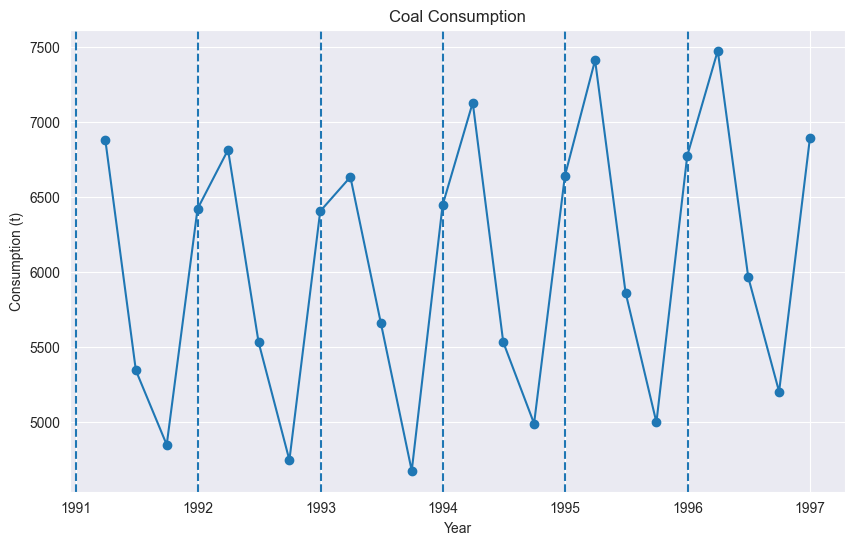

In [357]:
demo_coal_data(coal_consumption)

## 预处理函数

In [358]:
def calculate_other_components(coal_consumption, trend_mat):
    y = coal_consumption.copy()
    y_mat = y.values.reshape(6, 4)
    trend_mat = trend_mat.reshape(6, 4)
    y_detrend = pd.DataFrame(y_mat - trend_mat)
    season_pred = y_detrend.mean(axis=0)
    season_mat = pd.DataFrame(season_pred.repeat(6).values.reshape(6, 4, order='F'))  #order='F'按列排列,order='C'按行排列
    residual_mat = y_detrend - season_mat
    return y_mat, y_detrend, season_mat, residual_mat

In [359]:
def plot_data_decomposition(Trend,Season,Irregular):
    Trend=pd.DataFrame(Trend).values.reshape(24)
    Season=(Season).values.reshape(24)
    Irregular=(Irregular).values.reshape(24)
    dates = pd.date_range(start="1991-01", periods=24, freq='Q')#freq='Q'季度
    df=pd.DataFrame([Trend,Season,Irregular]).transpose()
    df.index=dates
    
    plt.figure(figsize=(10,6))
    plt.plot(df, marker='o', linestyle='-')
    plt.title('Trend Season Irregular Decomposition')
    plt.xlabel('Year')
    plt.ylabel('Consumption (t)')
    for year in range(1991, 1997):
        plt.axvline(pd.Timestamp(year=year, month=1, day=1), linestyle='--')
    plt.show()

## 预测函数

In [360]:
def pred_TrendSeansonIrregular(trend_mat,season_mat,y_mat,trend_tpye):
    if trend_tpye=='Const':
        print('Const')
        trend_concat = pd.concat([pd.Series(trend_mat.reshape(-1)), pd.Series([trend_mat.reshape(-1)[-1] for i in range(4)])]).reset_index(drop=True)
    else :
        trend_concat = trend_mat.reshape(-1)
    season_concat = pd.concat([pd.Series(season_mat.values.reshape(-1)), pd.Series(season_mat.values.reshape(-1)[:4])]).reset_index(drop=True)
    
    y_concat = pd.concat([pd.Series(y_mat.reshape(-1)), pd.Series(np.nan for i in range(4))]).reset_index(drop=True)
    
    # 使用转置创建DataFrame
    df = pd.DataFrame([trend_concat, season_concat+trend_concat, y_concat]).T
    df.columns = ['trend_data', 'pred_data', 'raw_data']  # 为列命名
    df
    return df

In [361]:
def plot_prediction(df,title):
    plt.figure(figsize=(10,6))
    #标明不同颜色这线段的含义
    plt.plot(df['trend_data'], marker='*', linestyle='--', label='Trend')
    plt.plot(df['pred_data'], marker='o', linestyle='-', label='Prediction')
    plt.plot(df['raw_data'], marker='.', linestyle='-', label='Actual')
    plt.legend()#显示图例
    plt.title(title+' prediction')
    plt.xlabel('Year')
    plt.ylabel('Consumption (t)')
    plt.show()

### 分段平均拟合趋势

In [362]:
def yearly_divided_avg(coal_consumption):
    y = coal_consumption.copy()
    y_mat = y.values.reshape(6, 4)
    trend_mat = pd.DataFrame(y_mat).mean(axis=1).repeat(4).values
    return trend_mat.reshape(6,4)

### 滑动平均拟合趋势

In [363]:
# Creating a copy of coal_consumption
def moving_avg(coal_consumption):
    y = coal_consumption.copy()
    y_mat=y.values.reshape(6,4)
    #moving average
    trend_mat=pd.DataFrame(y).rolling(window=4).mean().values
    trend_mat[:3]=pd.Series([y[:4].mean() for i in range(3)]).values.reshape(3,-1)
    trend_mat=trend_mat.reshape(6,4)
    return trend_mat

### 最小二乘回归估计趋势
$T_t=\alpha+\beta t,t=1,2,3...$

In [364]:
def least_squre_trend(coal_consumption):
    y=coal_consumption.copy()
    y=y.values.reshape(-1,1)
    x=np.arange(1,25).reshape(-1,1)
    x=np.concatenate((np.ones((24,1)),x),axis=1)
    [alpha,beta]=np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
    trend_mat=np.array([alpha,beta]).T.dot(x.T).T
    trend_mat=trend_mat.reshape(6,4)
    
    x=np.arange(1,29).reshape(-1,1)
    x=np.concatenate((np.ones((28,1)),x),axis=1)
    trend_mat_pred=np.array([alpha,beta]).T.dot(x.T).T
    trend_mat_pred=trend_mat_pred.reshape(7,4)
    return trend_mat,trend_mat_pred

### 二次曲线拟合趋势

In [365]:
def second_order_trend(coal_consumption):
    y=coal_consumption.copy()
    y=y.values.reshape(-1,1)
    x=np.arange(1,25).reshape(-1,1)
    x=np.concatenate((np.ones((24,1)),x,x**2),axis=1)
    [alpha,beta,gamma]=np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
    trend_mat=np.array([alpha,beta,gamma]).T.dot(x.T).T
    trend_mat=trend_mat.reshape(6,4)
    
    x=np.arange(1,29).reshape(-1,1)
    x=np.concatenate((np.ones((28,1)),x,x**2),axis=1)
    trend_mat_pred=np.array([alpha,beta,gamma]).T.dot(x.T).T
    trend_mat_pred=trend_mat_pred.reshape(7,4)
    return trend_mat,trend_mat_pred

# 分段平均拟合趋势的结果汇总

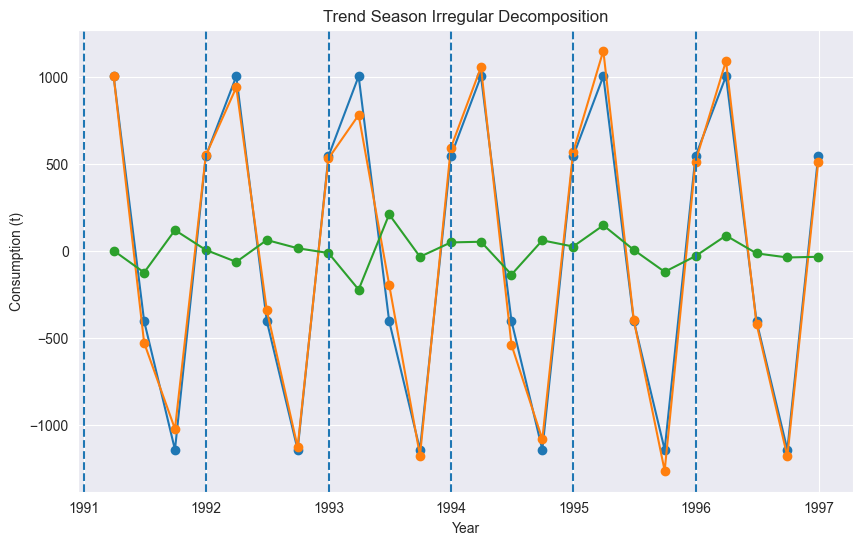

Const


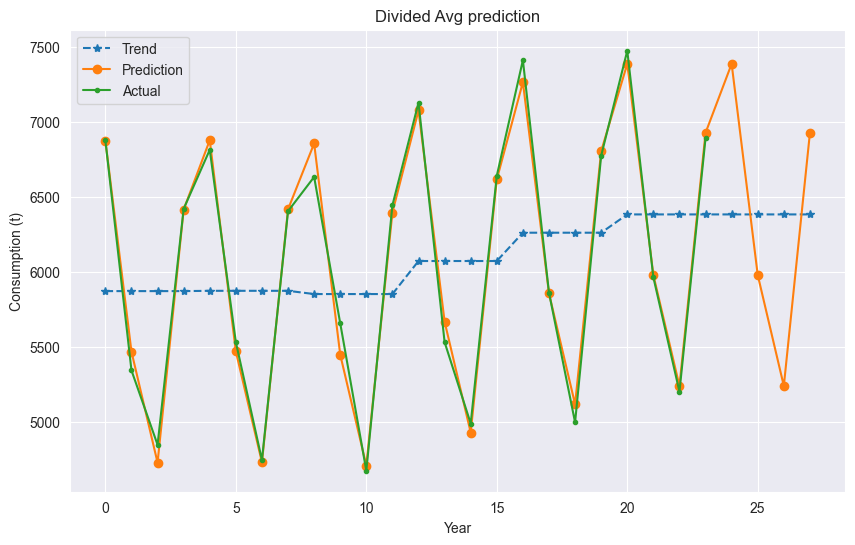

In [366]:
trend_mat= yearly_divided_avg(coal_consumption)
y_mat,y_detrend, season_mat, residual_mat = calculate_other_components(coal_consumption,trend_mat)
plot_data_decomposition(season_mat, y_detrend, residual_mat)
# 预测
df = pred_TrendSeansonIrregular(trend_mat, season_mat, y_mat, 'Const')
plot_prediction(df, 'Divided Avg')

# 移动平均复古及趋势的结果汇总

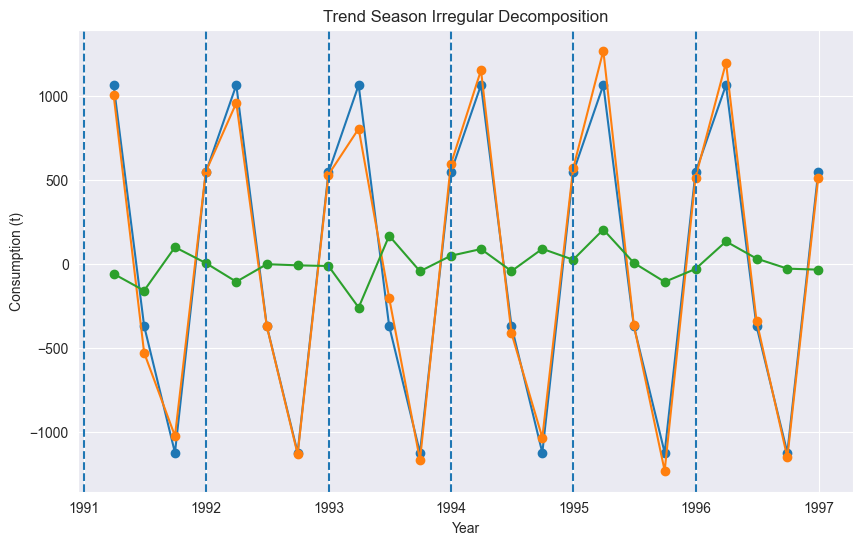

Const


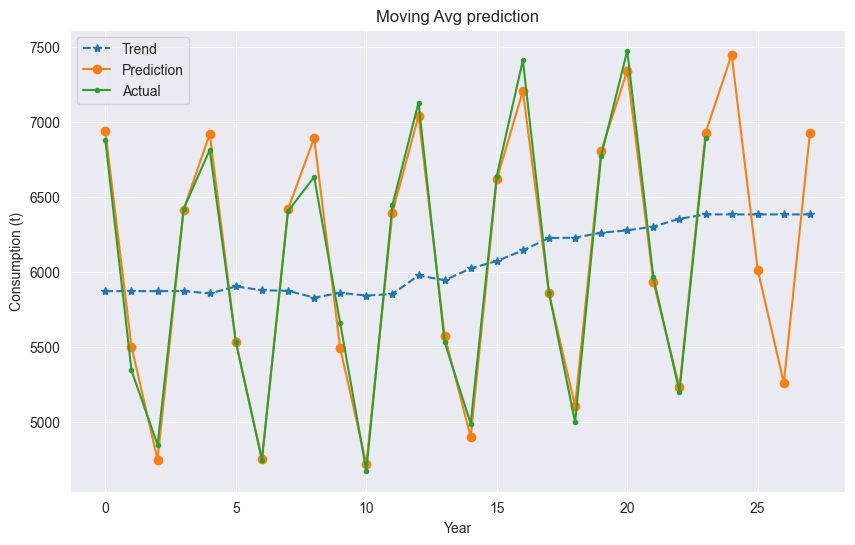

In [367]:
trend_mat= moving_avg(coal_consumption)
y_mat,y_detrend, season_mat, residual_mat = calculate_other_components(coal_consumption,trend_mat)
plot_data_decomposition(season_mat, y_detrend, residual_mat)
# 预测
df = pred_TrendSeansonIrregular(trend_mat, season_mat, y_mat,'Const')
plot_prediction(df, 'Moving Avg')

# 最小二乘回归估计趋势的结果汇总

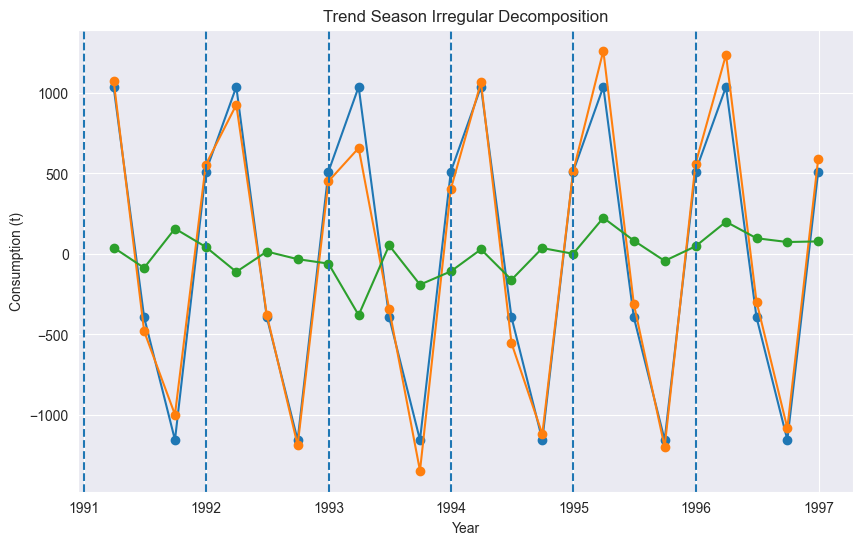

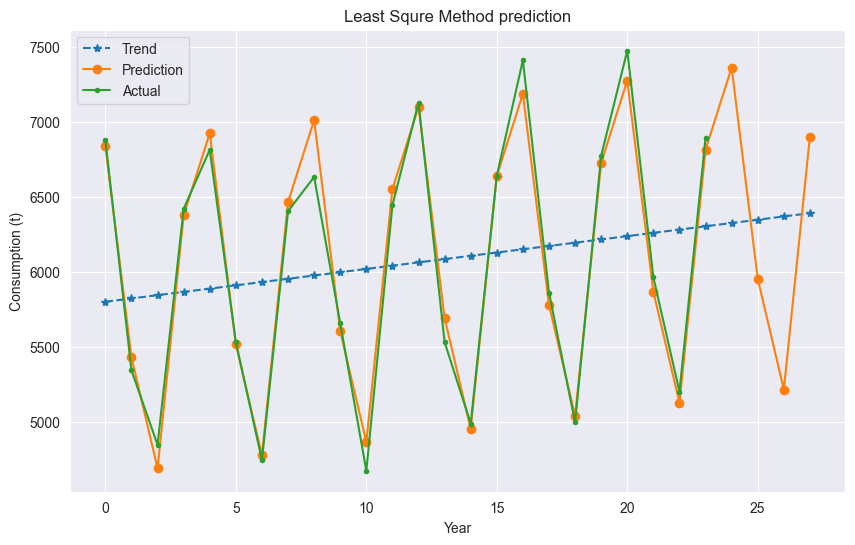

In [368]:
trend_mat,trend_mat_pred= least_squre_trend(coal_consumption)
y_mat,y_detrend, season_mat, residual_mat = calculate_other_components(coal_consumption,trend_mat)
plot_data_decomposition(season_mat, y_detrend, residual_mat)
# 预测
df = pred_TrendSeansonIrregular(trend_mat_pred, season_mat, y_mat,'else')
plot_prediction(df, 'Least Squre Method')

# 二次曲线拟合趋势的结果汇总

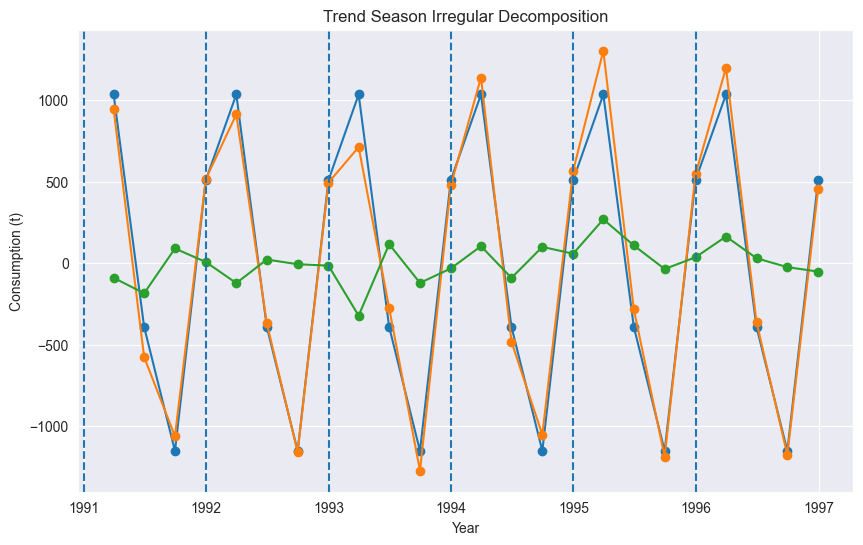

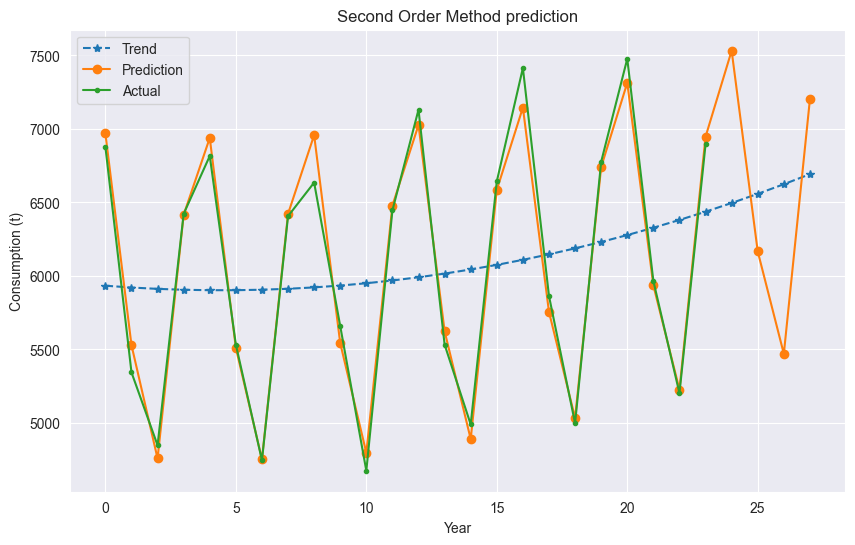

In [369]:
trend_mat,trend_mat_pred= second_order_trend(coal_consumption)
y_mat,y_detrend, season_mat, residual_mat = calculate_other_components(coal_consumption,trend_mat)
plot_data_decomposition(season_mat, y_detrend, residual_mat)
# 预测

df = pred_TrendSeansonIrregular(trend_mat_pred, season_mat, y_mat,'else')
plot_prediction(df, 'Second Order Method')